In [39]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Loading data and Preprocessing

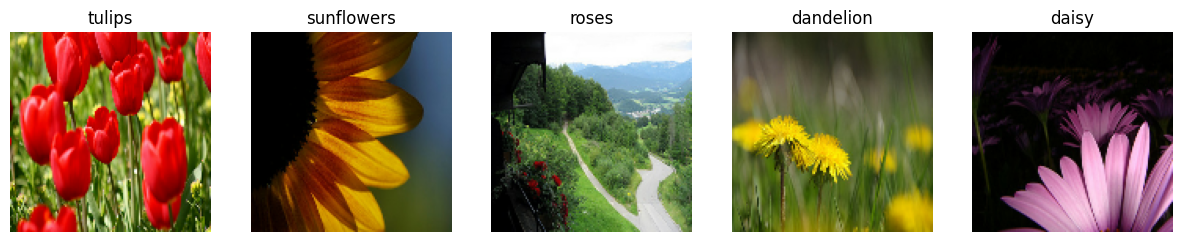

In [40]:
# Loding Flowers dataset
dataset_name = "tf_flowers"
(ds_train, ds_test), ds_info = tfds.load(dataset_name, split=["train[:80%]", "train[80%:]"] , as_supervised=True, with_info=True)

# Data Preprocessing
IMG_SIZE = (128, 128)

# Preprocessing function
def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0
    return image, label

# Apply preprocessing and batching
BATCH_SIZE = 64
ds_train = ds_train.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Show one sample image per class
num_classes = ds_info.features['label'].num_classes
class_names = ds_info.features['label'].names
sampled_classes = set()

fig, axes = plt.subplots(1, num_classes, figsize=(15, 5))
i = 0
for image, label in ds_train.unbatch():
    if label.numpy() not in sampled_classes:
        sampled_classes.add(label.numpy())
        axes[i].imshow(image)
        axes[i].set_title(class_names[label.numpy()])
        axes[i].axis("off")
        i += 1
    if len(sampled_classes) == num_classes:
        break
plt.show()

# MobileNetV2 model with Fine Tuning

In [58]:
# Load MobileNetV2 without top layer
base_model = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights="imagenet")
base_model.trainable = False  # Freeze base model

# Add new layers
global_avg_layer = tf.keras.layers.GlobalAveragePooling2D()
output_layer = tf.keras.layers.Dense(ds_info.features['label'].num_classes, activation="softmax")

model = tf.keras.Sequential([
    base_model,
    global_avg_layer,
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    output_layer
])

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Train initial model
EPOCHS = 5  #  epochs before fine-tuning
history = model.fit(ds_train, validation_data=ds_test, epochs=EPOCHS)

# Save accuracy before fine-tuning
initial_accuracy = history.history["val_accuracy"][-1]

# Unfreeze only the last 15 layers
for layer in base_model.layers[-15:]:
    layer.trainable = True

# Add a learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=2, verbose=1)

# Compile with a much smaller learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Fine-tune model for 3 epochs
EPOCHS_FINE_TUNE = 3
history_fine = model.fit(ds_train, validation_data=ds_test, epochs=EPOCHS_FINE_TUNE, callbacks=[lr_scheduler])

# Save accuracy after fine-tuning
final_accuracy = history_fine.history["val_accuracy"][-1]
print(f"Accuracy after fine-tuning: {final_accuracy:.4f}")

# Save model in recommended format
model.save("flowers_fine_tuned.keras")

Epoch 1/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.3831 - loss: 1.8067 - val_accuracy: 0.7439 - val_loss: 0.7662
Epoch 2/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.7613 - loss: 0.7069 - val_accuracy: 0.8283 - val_loss: 0.5287
Epoch 3/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8105 - loss: 0.5266 - val_accuracy: 0.8488 - val_loss: 0.4450
Epoch 4/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.8555 - loss: 0.4080 - val_accuracy: 0.8597 - val_loss: 0.4043
Epoch 5/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.8730 - loss: 0.3529 - val_accuracy: 0.8556 - val_loss: 0.3834
Epoch 1/3
46/46 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.7842 - loss: 0.6025 - val_accuracy: 0.8610 - val_loss: 0.3883 - learning_rate: 1.0000e-06
Epoch 2/3
46/46 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.8031 - loss: 0.5980 - val_accuracy: 0.8556 - val_loss: 0.3953 - learning_rate: 1.0000e-06
Epoch 3/3
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8013 - 

# Accuracy after fine tuning is ~85%

# Testing and Prediction

Raw label: [4 2 2 2 1 1 1 2 3 3 4 3 3 2 2 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Processed label: 4


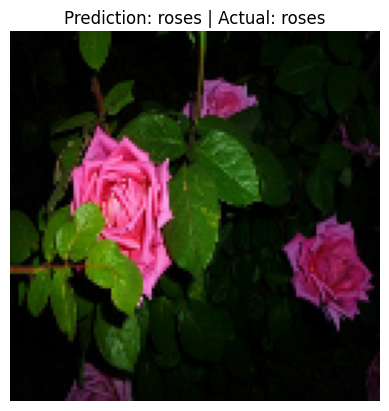

In [38]:
for image, label in ds_test.take(1):
    print("Raw label:", label.numpy())  # Debugging line

    prediction = model.predict(tf.expand_dims(image[0], axis=0))
    predicted_label = tf.argmax(prediction, axis=1).numpy()[0]

    class_names = ds_info.features['label'].names

    # Extract only the first label
    actual_label = label.numpy()[0]

    print("Processed label:", actual_label)  # Debugging line

    # Display image with prediction
    plt.imshow(image[0])
    plt.title(f"Prediction: {class_names[predicted_label]} | Actual: {class_names[actual_label]}")
    plt.axis("off")
    plt.show()